In [43]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,GRU

In [44]:
#loading data 
sales_data = pd.read_csv('./sales_train_v2.csv')
item_cat = pd.read_csv('./item_categories.csv')
items = pd.read_csv('./items.csv')
shops = pd.read_csv('./shops.csv')
sample_submission = pd.read_csv('./sample_submission.csv')
test_data = pd.read_csv('./test.csv')

In [45]:
def basic_eda(df):
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)

In [46]:
print("=============================Sales Data=============================")
basic_eda(sales_data)
print("=============================Test data=============================")
basic_eda(test_data)
print("=============================Item Categories=============================")
basic_eda(item_cat)
print("=============================Items=============================")
basic_eda(items)
print("=============================Shops=============================")
basic_eda(shops)
print("=============================Sample Submission=============================")
basic_eda(sample_submission)

=============================Sales Data=============================
----------TOP 5 RECORDS--------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------Describe-------------
       date_block_num       shop_id       item_id    item_pri

In [47]:
sales_data['date'] = pd.to_datetime(sales_data['date'],format = '%d.%m.%Y')

In [48]:
dataset = sales_data.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')
dataset.reset_index(inplace = True)
dataset.head()

shop_id item_id item_cnt_day                       ...        \
date_block_num                            0   1  2  3  4  5  6  7 ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0 ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0 ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0 ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0 ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0 ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [49]:
dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')
# lets fill all NaN values with 0
dataset.fillna(0,inplace = True)
# lets check our data now 
dataset.head()

E:\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
E:\Anaconda3\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# train data
temp = dataset.values
x_train = []
y_train = []

for sample in temp:
    for index in [22, 23]:
        # maxcnt = max(abs(max(sample[index:index+10])),abs(min(sample[index:index+10])))
        x_train.append([[x] for x in sample[index:index+10]])
        # x_train.append([[x/maxcnt if maxcnt != 0 else x] for x in sample[index:index+10]])
        y_train.append(sample[index+10])

x_train = np.array(x_train, dtype=float)
y_train = np.array(y_train, dtype=float)
# print(x_train.shape)

In [68]:
# test data
x_test = np.expand_dims(dataset.values[:,-10:],axis = 2)
# x_test = []
# maxcnts = []
# index = 24
# for sample in temp:
#     maxcnt = max(abs(max(sample[index:index+10])),abs(min(sample[index:index+10])))
#     x_test.append([[x/maxcnt if maxcnt != 0 else x] for x in sample[index:index+10]])
#     maxcnts.append(maxcnt)

# x_test = np.array(x_test, dtype=float)
# maxcnts = np.array(maxcnts, dtype=float)

In [69]:
print(x_train.shape,y_train.shape,x_test.shape)

(428400, 10, 1) (428400,) (214200, 10, 1)


In [70]:
my_model = Sequential()
my_model.add(GRU(units = 64,input_shape = (10,1)))
my_model.add(Dropout(0.4))
my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 64)                12672     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = my_model.fit(x_train,y_train,batch_size = 4096,epochs = 15, validation_split=0.2)

Train on 342720 samples, validate on 85680 samples
Epoch 1/15
342720/342720 [==============================] - 32s 95us/step - loss: 22.4857 - mean_squared_error: 22.4857 - val_loss: 1.1765 - val_mean_squared_error: 1.1765
Epoch 2/15
342720/342720 [==============================] - 31s 91us/step - loss: 21.9872 - mean_squared_error: 21.9872 - val_loss: 1.1235 - val_mean_squared_error: 1.1235
Epoch 3/15
342720/342720 [==============================] - 33s 95us/step - loss: 21.8237 - mean_squared_error: 21.8237 - val_loss: 1.0897 - val_mean_squared_error: 1.0897
Epoch 4/15
342720/342720 [==============================] - 30s 89us/step - loss: 21.7084 - mean_squared_error: 21.7084 - val_loss: 1.0761 - val_mean_squared_error: 1.0761
Epoch 5/15
342720/342720 [==============================] - 28s 82us/step - loss: 21.6347 - mean_squared_error: 21.6347 - val_loss: 1.0526 - val_mean_squared_error: 1.0526
Epoch 6/15
342720/342720 [==============================] - 28s 81us/step - loss: 21.5175

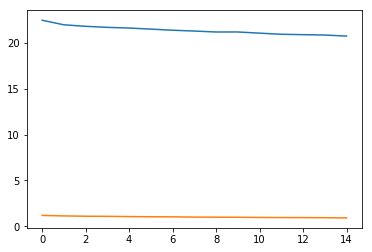

In [72]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

In [73]:
# creating submission file 
submission_pfs = my_model.predict(x_test)
# submission_pfs = dataset.values[:,-1:].mean(1)
print(submission_pfs.shape)

(214200, 1)


In [74]:
# print(submission_pfs.shape, maxcnts.shape)
# submission_pfs = submission_pfs.ravel()*maxcnts
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns
submission = pd.DataFrame({'ID':test_data['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('sub_maxcnt.csv',index = False)